In [4]:
import types
import os
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

np.random.seed(72018)

def plot_exponential_data():
    data = np.exp(np.random.normal(size=1000))
    plt.hist(data)
    plt.show()
    return data
    
def plot_square_normal_data():
    data = np.square(np.random.normal(loc=5, size=1000))
    plt.hist(data)
    plt.show()
    return data

%matplotlib inline

plot_exponential_data 
plot_square_normal_data

import warnings
warnings.simplefilter("ignore")


In [2]:
# The code was removed by Watson Studio for sharing.

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
data1 = df_data_2

In [4]:
data1.shape

(1338, 7)

In [5]:
data1.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [6]:
data1[data1.isnull().any(axis=1)]

,age,sex,bmi,children,smoker,region,charges


In [6]:
data1["sex"] = data1["sex"].astype('category')
data1["eligible_cat"] = data1["sex"].cat.codes
data1["smoker"] = data1["smoker"].astype('category')
data1["smoker_cat"] = data1["smoker"].cat.codes



In [7]:
data1.dtypes

age                int64
sex             category
bmi              float64
children           int64
smoker          category
region            object
charges          float64
eligible_cat        int8
smoker_cat          int8
dtype: object

In [8]:
#check to see if all columns are normally distributed
# Create a list of float colums to check for skewing. 
mask = data1.dtypes == np.float
float_cols = data1.columns[mask]

skew_limit = 0.75
skew_vals = data1[float_cols].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

skew_cols


,Skew
charges,1.51588


In [10]:
#one hot encoding Pandas supports this feature using get_dummies.
data1_OHE = pd.get_dummies(data1, columns=['region'])


In [11]:
data1_OHE

,age,sex,bmi,children,smoker,charges,eligible_cat,smoker_cat,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,16884.92400,0,1,0,0,0,1
1,18,male,33.770,1,no,1725.55230,1,0,0,0,1,0
2,28,male,33.000,3,no,4449.46200,1,0,0,0,1,0
3,33,male,22.705,0,no,21984.47061,1,0,0,1,0,0
4,32,male,28.880,0,no,3866.85520,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,10600.54830,1,0,0,1,0,0
1334,18,female,31.920,0,no,2205.98080,0,0,1,0,0,0
1335,18,female,36.850,0,no,1629.83350,0,0,0,0,1,0
1336,21,female,25.800,0,no,2007.94500,0,0,0,0,0,1


In [12]:
del data1_OHE['sex']
del data1_OHE['smoker']

In [13]:
#sns.set_context("talk", font_scale=1.4)
#sns.pairplot(data1_OHE, hue='charges');


In [14]:
'''Determining Normality
Making our target variable normally distributed often will lead to better results

If our target is not normally distributed, we can apply a transformation to it and then fit our regression to predict the transformed values.

How can we tell if our target is normally distributed? There are two ways:

Visually &Using a statistical test'''

'Determining Normality\nMaking our target variable normally distributed often will lead to better results\n\nIf our target is not normally distributed, we can apply a transformation to it and then fit our regression to predict the transformed values.\n\nHow can we tell if our target is normally distributed? There are two ways:\n\nVisually &Using a statistical test'

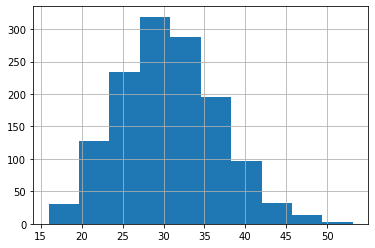

In [15]:
data1_OHE.bmi.hist()

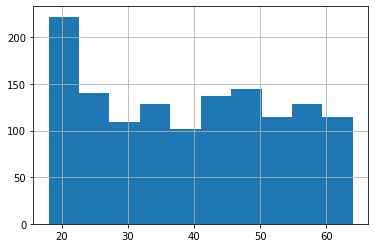

In [16]:
data1_OHE.age.hist()

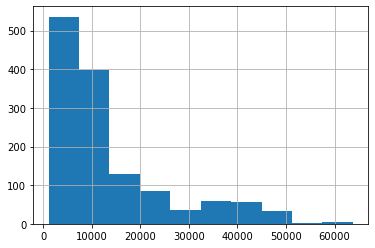

In [17]:
data1_OHE.charges.hist()

In [18]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
'''Without getting into Bayesian vs. frequentist debates, for the purposes of this lesson, the following will suffice:

This is a statistical test that tests whether a distribution is normally distributed or not. It isn't perfect, but suffice it to say:
This test outputs a "p-value". The higher this p-value is the closer the distribution is to normal.
Frequentist statisticians would say that you accept that the distribution is normal (more specifically: fail to reject the null hypothesis that it is normal) if p > 0.05.'''

'Without getting into Bayesian vs. frequentist debates, for the purposes of this lesson, the following will suffice:\n\nThis is a statistical test that tests whether a distribution is normally distributed or not. It isn\'t perfect, but suffice it to say:\nThis test outputs a "p-value". The higher this p-value is the closer the distribution is to normal.\nFrequentist statisticians would say that you accept that the distribution is normal (more specifically: fail to reject the null hypothesis that it is normal) if p > 0.05.'

In [19]:
normaltest(data1_OHE.charges.values)
#NormaltestResult(statistic=90.9746873700967, pvalue=1.7583188871696095e-20)

#p-value extremely low. Our y variable we've been dealing with this whole time was not normally distributed!

#Linear Regression assumes a normally distributed residuals which can be aided by transforming y variable. Let's try some common transformations to try and get y to be normally distributed:

#Log
#Square root
#Box cox
#Testing log
#The log transform can transform data that is significantly skewed right to be more normally distributed:

NormaltestResult(statistic=336.8851220567733, pvalue=7.019807901276197e-74)

In [20]:
log_data1_OHE = np.log(data1_OHE.charges)

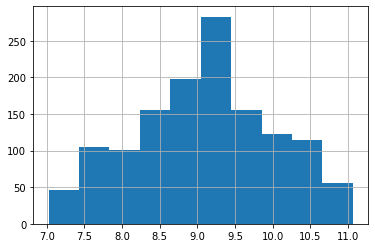

In [21]:
log_data1_OHE.hist()

In [22]:
sqrt_data1_OHE = np.sqrt(data1_OHE.charges)

(array([196., 230., 272., 278.,  97.,  83.,  49.,  82.,  46.,   5.]),
 array([ 33.4943861 ,  55.39775486,  77.30112362,  99.20449238,
        121.10786114, 143.0112299 , 164.91459866, 186.81796742,
        208.72133618, 230.62470495, 252.52807371]),
 <a list of 10 Patch objects>)

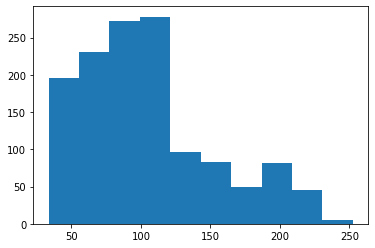

In [23]:
plt.hist(sqrt_data1_OHE)

In [24]:
from scipy.stats import boxcox

In [25]:
bc_result = boxcox(data1_OHE.charges)
boxcox_charges = bc_result[0]
lam = bc_result[1]

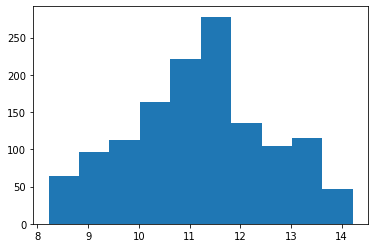

In [26]:
plt.hist(boxcox_charges);

In [27]:
normaltest(boxcox_charges)

NormaltestResult(statistic=54.4181017156977, pvalue=1.5249631686757666e-12)

In [28]:
normaltest(sqrt_data1_OHE)

NormaltestResult(statistic=112.4605295472106, pvalue=3.7975744156203163e-25)

In [29]:
normaltest(sqrt_data1_OHE) #data1_OHE is the one hot encoded version of original data

NormaltestResult(statistic=112.4605295472106, pvalue=3.7975744156203163e-25)

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)

In [31]:
lr = LinearRegression()

In [32]:
data1_OHE_lr = data1_OHE

In [33]:
data1_OHE

,age,bmi,children,charges,eligible_cat,smoker_cat,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,1,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,0,1


In [35]:
y_col = "charges"

X = data1_OHE_lr.drop(y_col, axis=1)
y = data1_OHE_lr[y_col]

In [36]:
X

,age,bmi,children,eligible_cat,smoker_cat,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,0,1
1,18,33.770,1,1,0,0,0,1,0
2,28,33.000,3,1,0,0,0,1,0
3,33,22.705,0,1,0,0,1,0,0
4,32,28.880,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,1,0,0,1,0,0
1334,18,31.920,0,0,0,1,0,0,0
1335,18,36.850,0,0,0,0,0,1,0
1336,21,25.800,0,0,0,0,0,0,1


In [38]:
#SkLearn object. 
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)
x_non_pf = data1_OHE_lr.drop(y_col, axis=1)

In [39]:
X.shape

(1338, 9)

In [40]:
X_pf.shape

(1338, 54)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3, 
                                                    random_state=72018)

In [42]:
#standard scaler . Data transformed to a scale from 0 to 1
s = StandardScaler()
X_train_s = s.fit_transform(X_train)

In [43]:
# Instructor Solution
bc_result2 = boxcox(y_train)
y_train_bc = bc_result2[0]
lam2 = bc_result2[1]

In [44]:
'''As before, we'll now:

Fit regression
Transform testing data
Predict on testing data'''

"As before, we'll now:\n\nFit regression\nTransform testing data\nPredict on testing data"

In [45]:
y_train_bc.shape

(936,)

In [46]:
lr.fit(X_train_s, y_train_bc)
X_test_s = s.transform(X_test)

y_pred_bc = lr.predict(X_test_s)

In [47]:
from scipy.special import inv_boxcox

In [48]:
boxcox_charges[:10]

array([12.12897974,  8.80859638, 10.14752106, 12.53495031,  9.94563694,
        9.90418624, 11.04885105, 10.86593766, 10.67769856, 12.96188984])

In [49]:
y_pred_tran = inv_boxcox(y_pred_bc,lam2)
r2_score(y_pred_tran,y_test)

0.7370186408610464

In [50]:
lr = LinearRegression()
lr.fit(X_train_s,y_train)
lr_pred = lr.predict(X_test_s)
r2_score(lr_pred,y_test)

0.768777733149136

In [51]:
#Pure linear regression. NON-POLYNOMIAL FEATURES

In [52]:
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(x_non_pf, y, test_size=0.3, 
                                                    random_state=72018)

lr_non_polynomial = LinearRegression()
lr.fit(X_train_LR, y_train_LR)

y_pred_LR = lr.predict(X_test_LR)
r2_score(y_pred_LR,y_test_LR)

0.6405524908736682

In [53]:
lr_fit = lr.fit(X_train, y_train)
lr_fit_stanLR = lr.fit(X_train_LR, y_train_LR)

In [54]:
#Conclusion: for this data set non-scalling, using features as defined in dataset without polynomial scaling the r squared value is significantly less than with scaling, polynomial shift

In [55]:
# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')

from sklearn.linear_model import Ridge, Lasso

# The lasso regression model
lassor = Lasso(alpha=0.0001)
lassor = lassor.fit(X_train, y_train)
Y_pred_lr = lassor.predict(X_train)

# The ridge regression model
rr = Ridge(alpha=0.001)
rr = rr.fit(X_train, y_train)
Y_pred_rr = rr.predict(X_train)

In [56]:
coefficients = pd.DataFrame()

In [57]:
coefficients['lasso regression'] = lassor.coef_.ravel()
coefficients['ridge regression'] = rr.coef_.ravel()

coefficients = coefficients.applymap(abs)

coefficients.describe()  # Huge difference in scale between non-regularized vs regularized regression

,lasso regression,ridge regression
count,54.000000,54.000000
mean,1702.250410,742.519796
std,6804.925939,1843.132684
min,0.000000,0.000000
25%,5.664347,6.509581
50%,73.985735,102.918744
75%,720.431349,602.257837
max,44792.149845,9438.424336


In [58]:
coefficients2 = pd.DataFrame()

coefficients2['linear regression (Polynomial)'] = lr_fit.coef_.ravel()
coefficients2['linear regression (Standard)'] = lr_fit_stanLR.coef_.ravel()
coefficients2 = coefficients2.applymap(abs)

coefficients2.describe()  #  non-regularized coefficients

,linear regression (Polynomial),linear regression (Standard)
count,9.000000,9.000000
mean,3003.328229,3003.328229
std,7933.737330,7933.737330
min,52.028790,52.028790
25%,260.848376,260.848376
50%,370.784279,370.784279
75%,419.926614,419.926614
max,24152.634786,24152.634786


In [59]:
(coefficients>0).sum()

lasso regression    48
ridge regression    48
dtype: int64

In [62]:
(coefficients2>0).sum()

linear regression (Polynomial)    9
linear regression (Standard)      9
dtype: int64

In [67]:
from sklearn.metrics import mean_squared_error


def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

#L1 is absolute value
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))



#L2 is squared
from sklearn.linear_model import RidgeCV

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(X_train, y_train)

ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))


#Linear Regression
from sklearn.linear_model import LinearRegression

LRCV = LinearRegression().fit(X_train, y_train)

linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))




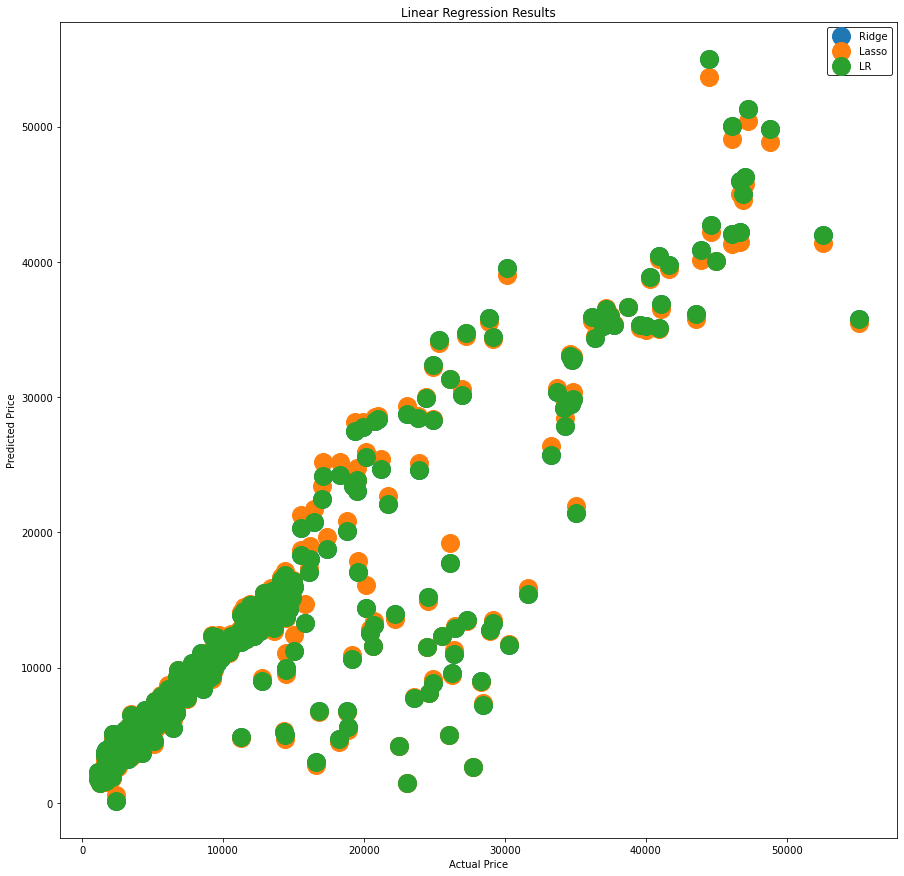

In [85]:
f = plt.figure(figsize=(15,15))
ax = plt.axes()

labels = ['Ridge', 'Lasso', 'LR']

models = [lassoCV, ridgeCV, LRCV]

for mod, lab in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test), 
             marker='o', ls='', ms=18.0, label=lab)


leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       title='Linear Regression Results');